# Synthetic Control Simulation

Sources
1. Causal Inference Mixtape
2. Causal Inferece for the Brave and True

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(777)

from toolz import partial
from scipy.optimize import fmin_slsqp

In [2]:
%cd ~

/Users/alexander.clark


In [3]:
from synth_control import *

## Generate Fake Data

For each unit $i$ and time period $t$, we observe features $A_{it}, B_{it},$ and $Y_{it}$. $Y_{it}$ is the outcome of interest and formed as a linear combination of $A_{it}$ and $B_{it}$. $A_{it}$ is drawn randomly at $t=0$ and $A_{it} = A_{it-1} + \epsilon_{it}$ for $t\geq 1$, where $\epsilon_{it}$ is normal noise. The same is true of $B_{it}$, with noise iid across units, time, and features.

The treated unit is a convex combo (`true_weights`) of the donor units, plus some random noise. 

In treatment periods, $Y_{it}$ is shifted up by 0.5 (`treatment_effect`) for the treated unit. 

In [4]:
features = 'ABY'
donor_units = range(3)
treated_unit = 'T'

n_periods = 10
periods = range(n_periods)
n_treament_periods = 3
pretreatment_periods = range(0, n_periods - n_treament_periods)
treatment_periods = range(n_periods - n_treament_periods, n_periods) # or post-treatment

treatment_effect = 0.5 # additive effect on Y 

In [5]:
data = pd.DataFrame()


# Construct Dataset for the donor units
for i in donor_units:
    for feature in features[0:-1]: # exclude the outcome feature
        for period in periods:
            
            # initialize at randomly
            if period == 0:
                data.loc[i,feature + str(period)] = np.random.normal() 
            
            # evolve according to random shock
            else:
                prev = data.loc[i,feature + str(period-1)]
                data.loc[i,feature + str(period)] = prev + np.random.normal(0,1)
      
    # Generate outcome variable
    for period in periods:
        # outcome is a linear combo of a and b
        data.loc[i,'Y' + str(period)] = .1*data.loc[i,'A'+str(period)] \
                            + .9*data.loc[i,'B'+str(period)] + np.random.normal(0, .01) # adjust var


In [6]:
# Create the Treated Object

# Untreated potential outcome as a combo of donors
true_weights = np.random.dirichlet(np.ones(len(donor_units)))

m = np.matrix(data)
convex_combo = np.array(np.dot(true_weights, m)).flatten()

# Think of this as Y_0 | D = 1, the potential outcome of no treatment for the treated unit
data.loc[treated_unit] = convex_combo + np.random.normal(0, .01, size = len(convex_combo)) # adjust var

# Treated outcome for treated unit
data.loc[treated_unit + 'treat'] = data.loc[treated_unit]
for treatment_period in treatment_periods:
    data.loc[treated_unit + 'treat','Y'+str(treatment_period)] += treatment_effect

In [7]:
# get dataframe with just pretreatment periods 

pretreatment_cols = []

for i in list(data):
    i2 = i
    for x in features:
        i2 = i2.lstrip(x)
    if int(i2) in pretreatment_periods:
        pretreatment_cols.append(i)
        
pretreatment_data = data[pretreatment_cols]

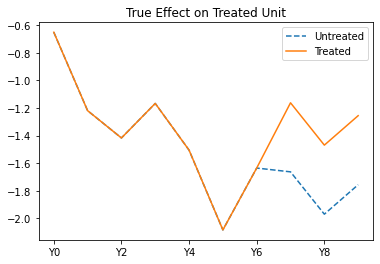

In [8]:
outcomes = ['Y'+str(x) for x in periods]
data.loc[treated_unit,outcomes].plot(linestyle = 'dashed', label = 'Untreated')
data.loc[treated_unit + 'treat',outcomes].plot(linestyle = 'solid', label = 'Treated')
plt.title("True Effect on Treated Unit")
plt.legend()
plt.show()

# Untreated represents the actual counterfactual (not synth control)

## Measure Treatment Effect with Synthetic Control

In [9]:
X1 = np.matrix(pretreatment_data.loc[treated_unit + 'treat']).T
X0 = np.matrix(pretreatment_data.loc[donor_units]).T
X0_all_periods = np.matrix(data.loc[donor_units]).T

outcome_cols = ['Y'+ str(x) for x in pretreatment_periods]
Y_donors = np.matrix(pretreatment_data.loc[list(donor_units), outcome_cols]).T
Y1 = np.matrix(pretreatment_data.loc[[treated_unit + 'treat'], outcome_cols]).T

In [10]:
n_features = len(features) * len(pretreatment_periods)

In [11]:
# Find V such that W(V) minimizes the mean squared prediction error
V_star, estimated_weights = find_best_V_w(X0, X1, Y_donors, Y1, n_features = n_features)

synthetic_unit = X0_all_periods*np.matrix(estimated_weights).T

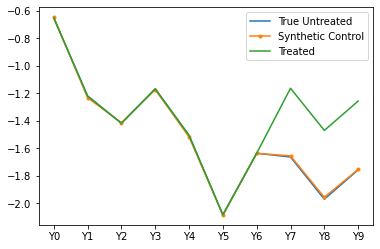

In [12]:
outcomes_all_periods = ['Y'+ str(x) for x in periods]

plt.plot(outcomes_all_periods, data.loc[treated_unit, outcomes_all_periods].values, label = 'True Untreated')
plt.plot(outcomes_all_periods, synthetic_unit[-len(periods):], label = 'Synthetic Control', marker = '.')
plt.plot(outcomes_all_periods, data.loc[treated_unit+'treat', outcomes_all_periods].values, label = 'Treated')

plt.legend()
plt.show()

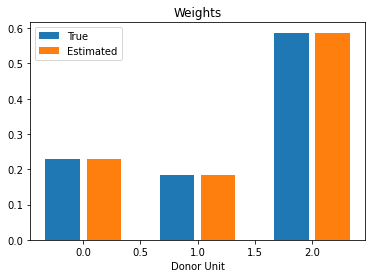

In [13]:
plt.bar(np.arange(len(true_weights))-0.18, true_weights, width = 0.3, label = "True")
plt.bar(np.arange(len(true_weights))+0.18, estimated_weights, width = 0.3, color = 'C1', label = 'Estimated')
plt.title("Weights")
plt.xlabel("Donor Unit")
plt.legend()

## Calculate $p$-values

In [14]:
placebo_effects = dict()
ratios = pd.Series()

treated_unit_treat = treated_unit + 'treat'
for unit in list(donor_units) + [treated_unit_treat]:

    synth_outcomes, true_outcomes, V_star, estimated_weights = synthetic_control(data = data,
                            features = features,
                            treated_unit = unit,
                            units = [x for x in list(donor_units)+[treated_unit] if x!= unit], # donors
                            periods = periods,
                            pretreatment_periods = pretreatment_periods,
                            n_features = n_features,
                            search_size = 100)
        
    placebo_effects[unit] = synth_outcomes, true_outcomes
    ratio = rmspe_ratio(synth_outcomes, true_outcomes, treatment_start = 7)
    ratios.loc[unit] = ratio

/var/folders/_r/5whyybsj5jlg0yywjfk54qpr0000gp/T/ipykernel_30489/471669146.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ratios = pd.Series()


In [15]:
ratios.sort_values(ascending = False, inplace = True)

rank = list(ratios.index).index(treated_unit_treat) + 1 

p_value = rank / len(ratios)
print(p_value, rank, len(ratios))

0.25 1 4
